Jason<br>
2401960183<br>
Deep Learning Final Exam No 1

Importing Libraries and mount drive from google drive for the large image dataset

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.python.keras.models import Sequential
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Multiply
from tensorflow.keras.models import Model
from google.colab import drive
drive.mount('/drive')

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Loading and splitting image and groundtruth dataset using ImageDataGenerator from Keras Processing Image Library, here i split the validation by 15%

In [2]:
base_directory = './Skin Cancer/'
images_folder = os.path.join(base_directory, 'Training_Data')
masks_folder = os.path.join(base_directory, 'Training_GroundTruth')

In [3]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Training_Data'],
        batch_size = 32,
        seed=2401960183,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Training_GroundTruth'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=2401960183,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Training_Data'],
        batch_size = 32,
        seed=2401960183,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Training_GroundTruth'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=2401960183,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 765 images belonging to 1 classes.
Found 765 images belonging to 1 classes.
Found 135 images belonging to 1 classes.
Found 135 images belonging to 1 classes.


In [45]:
test_image_generator = image_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Test_Data'],
        batch_size = 32,
        seed= 2401960183,
        subset='validation')

test_mask_generator = mask_datagen.flow_from_directory(
        base_directory,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Test_GroundTruth'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed= 2401960183,
        subset='validation')

test_generator = zip(test_image_generator, test_mask_generator)

Found 56 images belonging to 1 classes.
Found 56 images belonging to 1 classes.


In [4]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

Plot sample of input and mask image using the ImageDataGenerator instanstiated before 

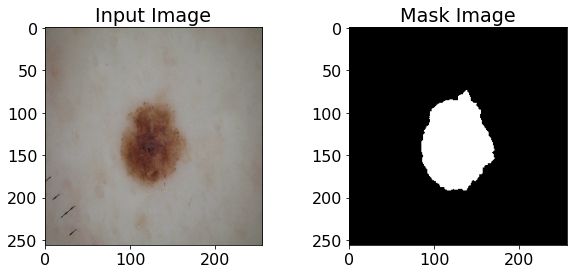

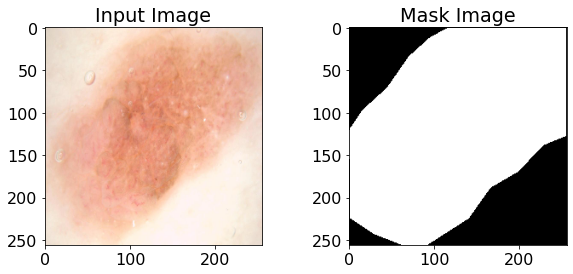

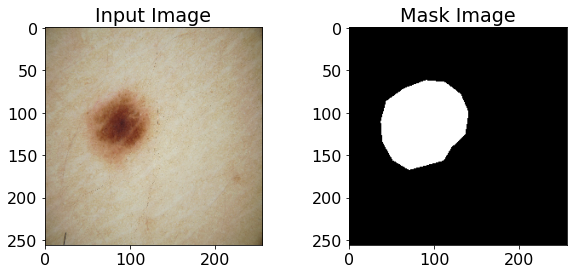

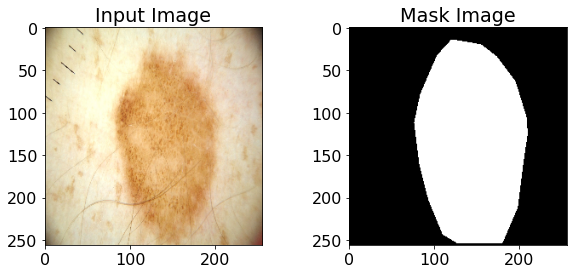

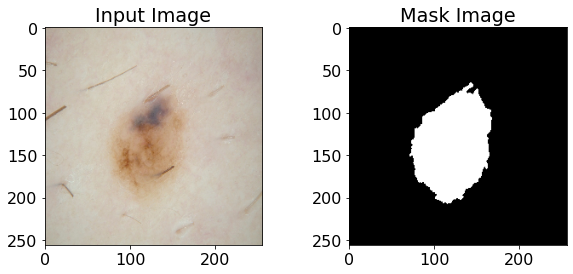

In [5]:
n = 0
for i,m in train_generator:
    img,mask = i,m
    current_mask = mask[0].astype(np.uint8)
    current_mask = current_mask[:,:,0]

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(10,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(current_mask, cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

<h1> 1. Architecture Of Model for Skin Lesion Segmentation, U-Net: Segmentation Architecture</h1>

<p> For the Model reference i will be using U-Net Model. For tasks involving picture segmentation, deep learning architecture U-Net is employed. Its distinctive "U" shape, which consists of a bottleneck layer connecting an encoding path (downsampling) and a decoding path (upsampling), gave rise to its name. The decoding path stretches the features back to the original picture size through transpose convolutional layers and concatenation with features from the encoding path, while the encoding path retrieves features from the input image through a succession of convolutional and max pooling layers. This enables the resulting segmentation map to recover fine details and precisely localize features. U-Net has demonstrated strong performance in a number of areas and is frequently used for biomedical picture segmentation.

Architecture itself consists a total of 4 encoder_block layers after the input layer, then have access to the hidden layer of CNN before going into four more decoder_block layers. Output is sigmoid because of the prediction results only in pixel values between 0 and 1.

In [6]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

Intersection over Union (IoU) measures the overlap between the predicted segmentation and the ground truth segmentation, represented by binary masks. IoU is widely used in image segmentation tasks because it provides a scalar value that summarizes the degree of overlap between the predicted and ground truth segmentations. This makes it a convenient metric for comparing different models and for tuning the parameters of a model. 

In [7]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   
        false_positives = np.sum(matches, axis=0) == 0  
        false_negatives = np.sum(matches, axis=1) == 0  
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

Model training using the above architecture and iou coefficient metrics

In [8]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ormalization)                  )                                                                 
                                                                                                  
 activation_15 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_15[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 32  8224       ['activation_15[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'activation_1[0][0]']           
          

<h1> 3x. U-Net Model Fitting and Evaluation Metrics</h1>

<p>Below the vanilla u-net model training resulting in an accuracy of 0.9286, val_accuracy: 0.8641, and val_iou_coef: 0.6133. The accuracy are high enough but the iou coefficient values are rather low considering that this is the metrics that is important for image segmentation. We will see a difference in the ground truths and predictions later below. However because of the high accuracy the mask itself also won't differ it shapes and likeness.

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=10)

Epoch 1/10
23/23 [==============================] - 63s 2s/step - loss: 0.4537 - iou_coef: 0.3360 - accuracy: 0.8097 - val_loss: 8.9476 - val_iou_coef: 0.2929 - val_accuracy: 0.2905
Epoch 2/10
23/23 [==============================] - 41s 2s/step - loss: 0.3171 - iou_coef: 0.4365 - accuracy: 0.8806 - val_loss: 2.2776 - val_iou_coef: 0.3528 - val_accuracy: 0.7525
Epoch 3/10
23/23 [==============================] - 45s 2s/step - loss: 0.2834 - iou_coef: 0.4706 - accuracy: 0.8944 - val_loss: 13.3666 - val_iou_coef: 0.4309 - val_accuracy: 0.6746
Epoch 4/10
23/23 [==============================] - 41s 2s/step - loss: 0.2607 - iou_coef: 0.4975 - accuracy: 0.9043 - val_loss: 4.3185 - val_iou_coef: 0.5649 - val_accuracy: 0.8163
Epoch 5/10
23/23 [==============================] - 46s 2s/step - loss: 0.2276 - iou_coef: 0.5335 - accuracy: 0.9137 - val_loss: 4.2930 - val_iou_coef: 0.5403 - val_accuracy: 0.7920
Epoch 6/10
23/23 [==============================] - 44s 2s/step - loss: 0.2283 - iou_coef

Generate a random validation images, masks, and predict their ground truth mask, the predicton will be mapped to 0 or 1 depending on their predicted values

In [10]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 0s 416ms/step


Plotting the image, mask, with it's predicted mask

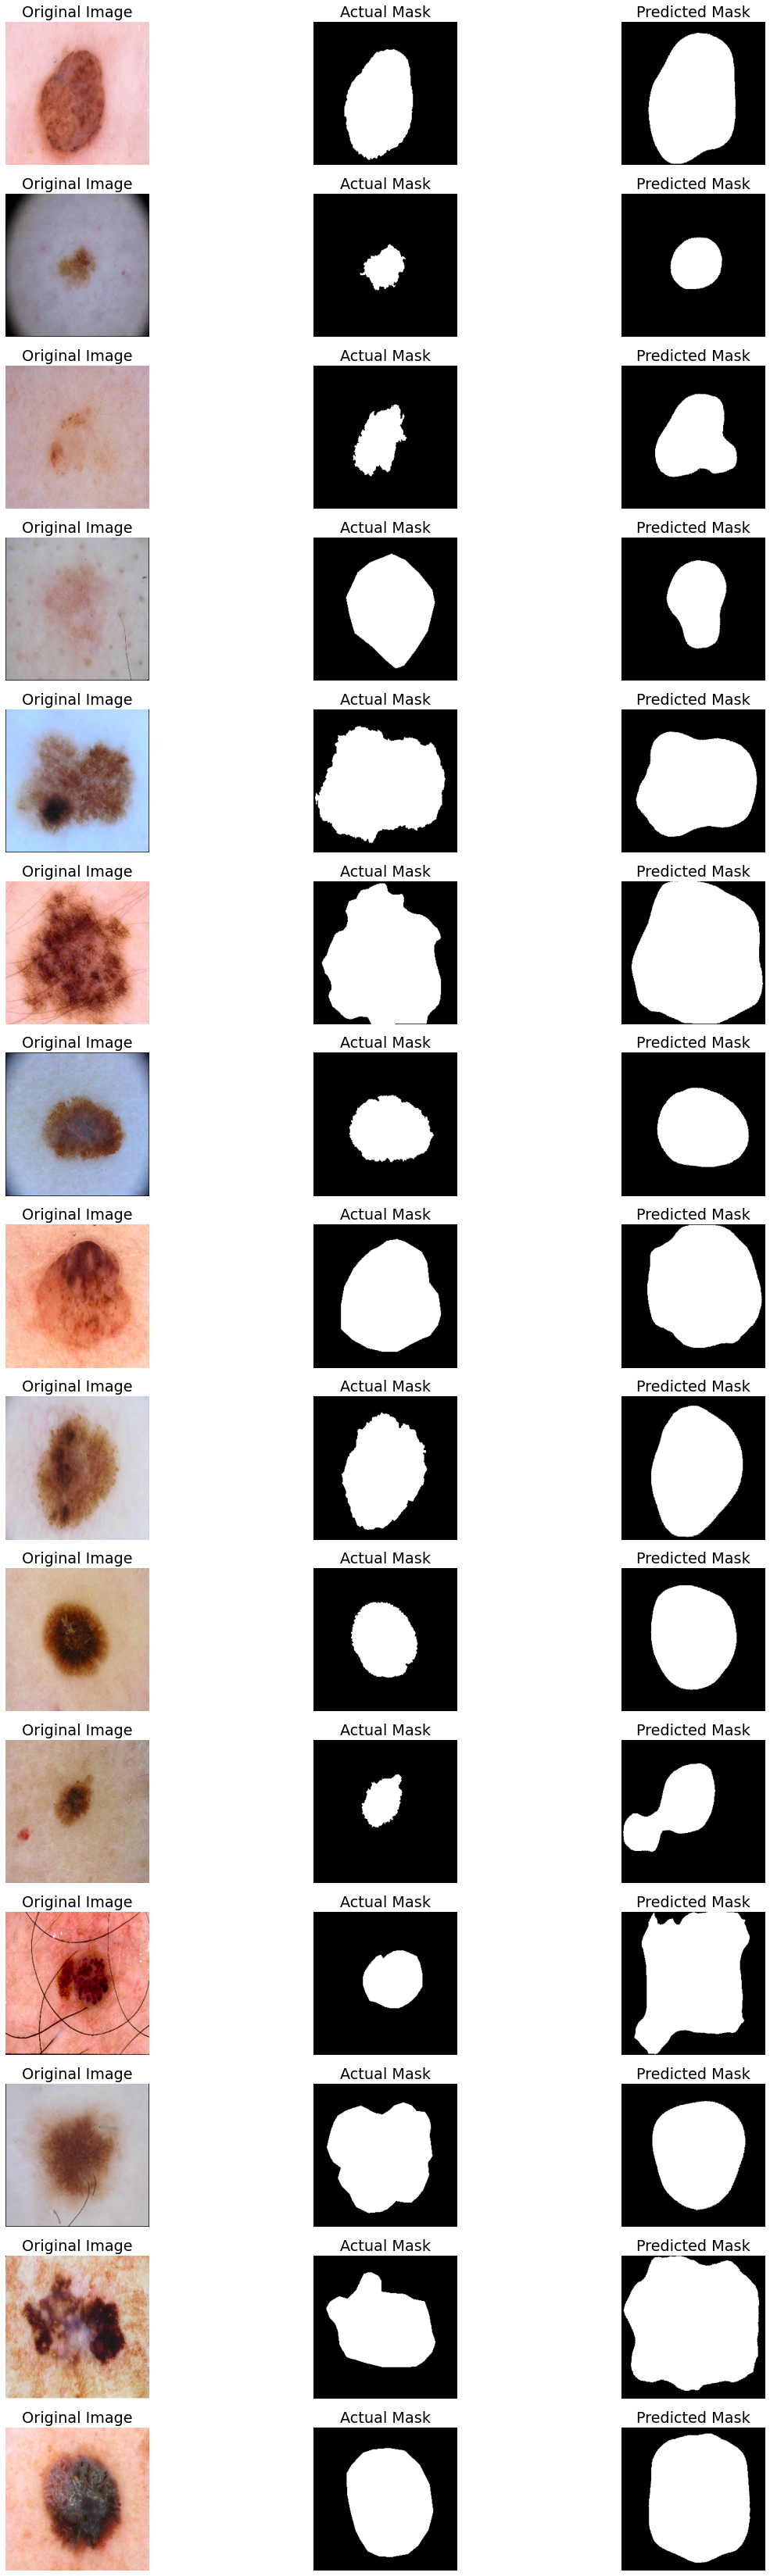

In [11]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')

    current_val_mask = val_mask_samples[i].astype(np.uint8)
    current_val_mask = current_val_mask[:,:,0]

    axarr[i,1].imshow(current_val_mask, cmap='gray')
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')

    current_predicted_mask = predicted_masks[i].astype(np.uint8)
    current_predicted_mask = current_predicted_mask[:,:,0]

    axarr[i,2].imshow(current_predicted_mask, cmap='gray')
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

<h1> 2. Adding a soft attention block to the architecture</h1>

When focusing on certain areas of an input image, such as a feature map produced by a Convolutional Neural Network (CNN), soft attention are usually used.
In order to determine each element's importance in the final prediction, soft attention scores or weights are calculated for each pixel (for example) in the feature map. After that, the attended features are obtained by multiplying the feature map by the element-wise attention weights.
<br>
<p> The soft attention block takes the features from the encoding path as input and returns the attended features and the attention weights. The attended features are then concatenated with the features from the decoding path and passed through the remaining layers to produce the final segmentation map.






In [17]:
def attention_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    attention = Conv2D(1, 1, activation='sigmoid')(x)
    attended_features = Multiply()([input, attention])

    return attended_features

In [18]:
def build_unet_attention(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = attention_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net-Soft-Attention")
    return model

In [19]:
input_shape = (img_dim, img_dim, 3)
model_attention = build_unet_attention(input_shape)
model_attention.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model_attention.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 256, 256, 32  128        ['conv2d_41[0][0]']              
 ormalization)                  )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 activation_53 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_53[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 32  8224       ['activation_53[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_7[0][0]',     
                                )                                 'activation_39[0][0]']          
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_7[0][0]']          
          

In [20]:
history = model_attention.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=10)

Epoch 1/10
23/23 [==============================] - 46s 2s/step - loss: 0.4750 - iou_coef: 0.3262 - accuracy: 0.7977 - val_loss: 0.5898 - val_iou_coef: 0.1478 - val_accuracy: 0.7039
Epoch 2/10
23/23 [==============================] - 39s 2s/step - loss: 0.3200 - iou_coef: 0.4206 - accuracy: 0.8837 - val_loss: 5.7871 - val_iou_coef: 0.2794 - val_accuracy: 0.3216
Epoch 3/10
23/23 [==============================] - 41s 2s/step - loss: 0.2905 - iou_coef: 0.4666 - accuracy: 0.8958 - val_loss: 0.8236 - val_iou_coef: 0.0625 - val_accuracy: 0.7059
Epoch 4/10
23/23 [==============================] - 42s 2s/step - loss: 0.2766 - iou_coef: 0.4735 - accuracy: 0.8958 - val_loss: 0.7615 - val_iou_coef: 0.0896 - val_accuracy: 0.7124
Epoch 5/10
23/23 [==============================] - 44s 2s/step - loss: 0.2594 - iou_coef: 0.5032 - accuracy: 0.9035 - val_loss: 0.8820 - val_iou_coef: 0.0488 - val_accuracy: 0.7166
Epoch 6/10
23/23 [==============================] - 44s 2s/step - loss: 0.2390 - iou_coef:

Using the test_generator to generate samples from test images folder

In [46]:
random_val_samples = test_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks_vanilla = model.predict(val_image_samples) # Vanilla U-Net Model
predicted_masks_attention = model_attention.predict(val_image_samples) # Soft Attention U-Net Model

predicted_masks_vanilla[predicted_masks >= 0.5] = 1
predicted_masks_vanilla[predicted_masks < 0.5] = 0

predicted_masks_attention[predicted_masks >= 0.5] = 1
predicted_masks_attention[predicted_masks < 0.5] = 0

1/1 [==============================] - 0s 30ms/step


<h1> 3. Plotting Segmentation Results of the Model with and without Soft Attention</h1>

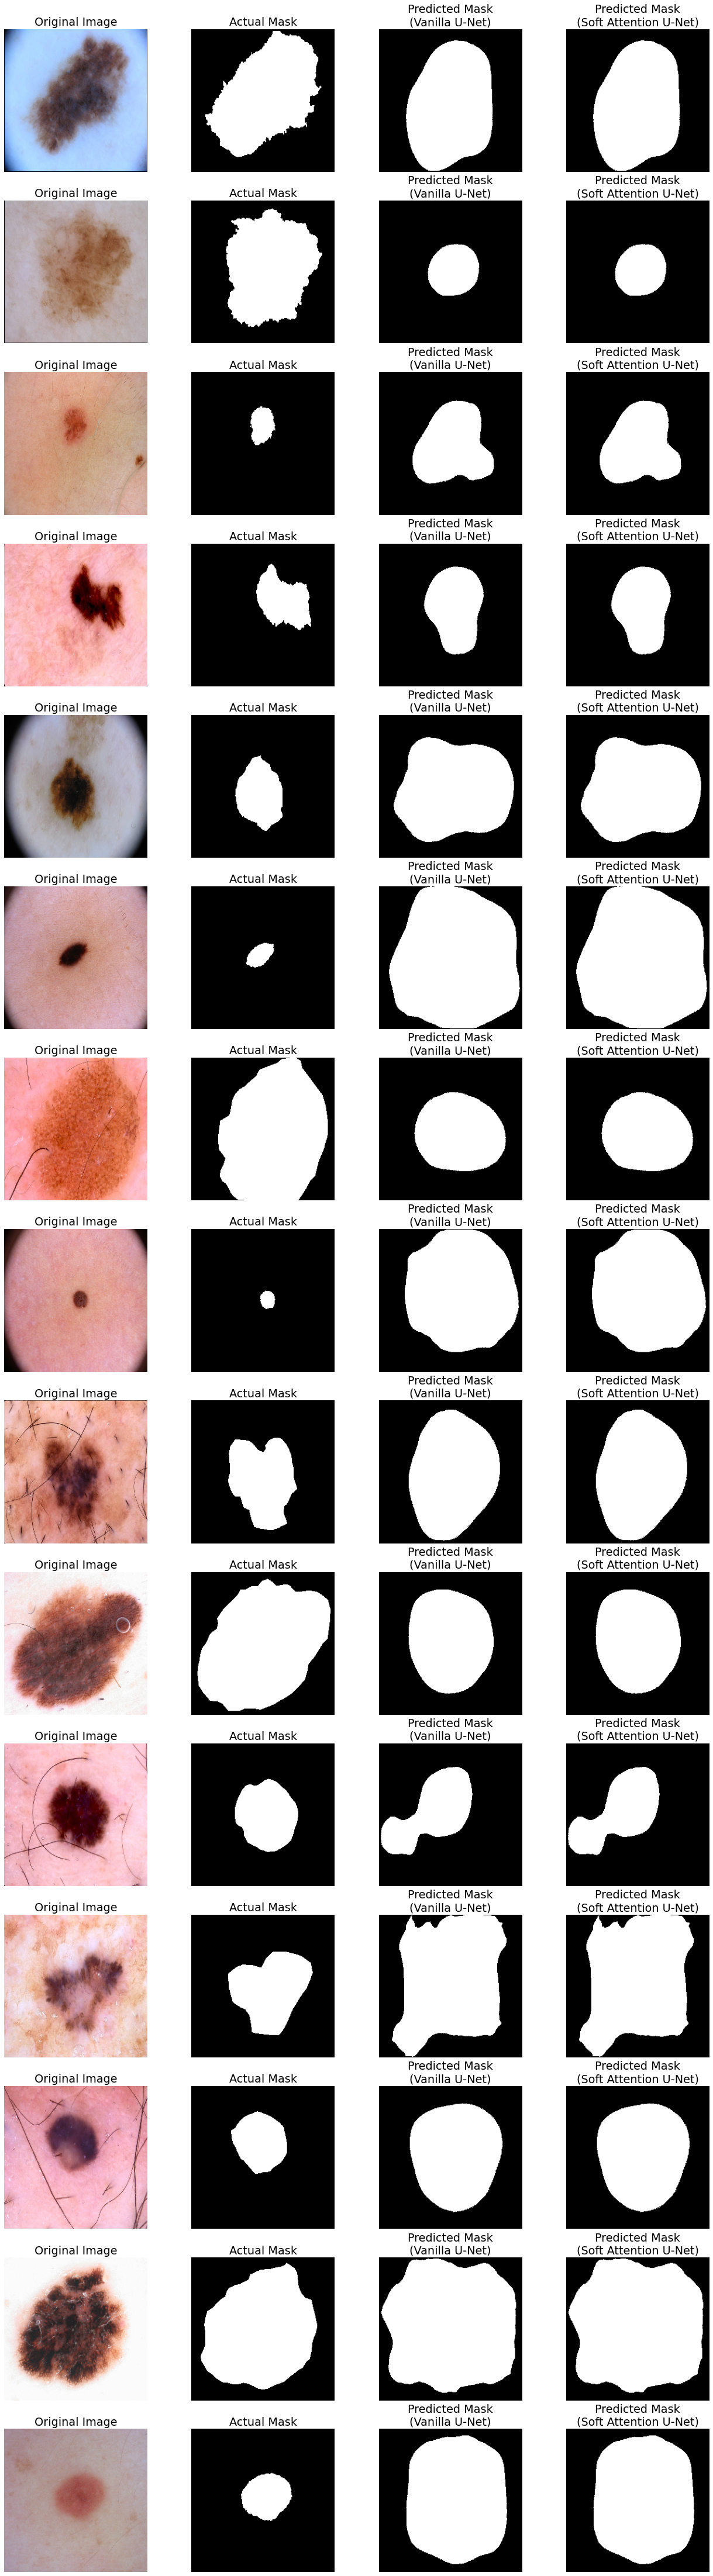

In [47]:
f, axarr = plt.subplots(15,4,figsize=(22, 80))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')

    current_val_mask = val_mask_samples[i].astype(np.uint8)
    current_val_mask = current_val_mask[:,:,0]

    axarr[i,1].imshow(current_val_mask, cmap='gray')
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')

    current_predicted_mask = predicted_masks_vanilla[i].astype(np.uint8)
    current_predicted_mask = current_predicted_mask[:,:,0]

    axarr[i,2].imshow(current_predicted_mask, cmap='gray')
    axarr[i,2].title.set_text('Predicted Mask\n(Vanilla U-Net)')
    axarr[i,2].axis('off')

    current_predicted_mask_attention = predicted_masks_attention[i].astype(np.uint8)
    current_predicted_mask_attention = current_predicted_mask_attention[:,:,0]

    axarr[i,3].imshow(current_predicted_mask_attention, cmap='gray')
    axarr[i,3].title.set_text('Predicted Mask\n(Soft Attention U-Net)')
    axarr[i,3].axis('off')